![header](header.png)

# Procesamiento Digital de Señales en Sistemas Embebidos
---


# TP4: Filtrado Digital *(parte 2)*

## Introducción

El algoritmo Pan-Tompkins se usa comúnmente para detectar complejos QRS en señales electrocardiográficas (ECG). El complejo QRS representa la despolarización ventricular y el pico principal visible en una señal de ECG (ver figura). Esta característica lo hace especialmente adecuado para medir la frecuencia cardíaca, la primera forma de evaluar el estado de salud del corazón.

El algoritmo de Pan-Tompkins aplica una serie de filtros para resaltar el contenido de frecuencia del QRS y eliminar el ruido de fondo. Luego deriva y cuadra la señal para amplificar la contribución QRS, lo que hace que la identificación del complejo QRS sea más sencilla. Finalmente integra la señal y aplica umbrales para detectar los picos.

![pan-tompkins](pan-tompkins.png)

El filtro aplicado en el primer paso para aumentar la relación señal-ruido consiste en un pasa-banda. Se sugiere un ancho de banda de filtro de 5 a 15 Hz para maximizar la contribución de QRS y reducir el ruido muscular, la desviación de la línea de base, la interferencia de la línea eléctrica y el contenido de frecuencia de onda P/onda T. Este filtro estaba originalmente implementado mediante un pasa bajos y un pasa altos, y presentaba una atenuación de aproximadamente 20dB para frecuencias de 1Hz y 50Hz.

## Consignas

A partir de una señal de ECG descargada del Repositorio de Physionet, replicar la acción de filtrado correspondiente a la primera etapa del algoritmo de Pan-Tompkins.
Para ello:
1. Proponer dos diseños de filtros con los requerimientos mencionados, utilizando un filtro de tipo FIR y uno de tipo IIR.
2. Probar dichos filtros sobre un registro de ECG en Python.
3. Implementar ambos filtros en el ESP32, y probarlos también utilizando la misma señal de ECG.

## Filtrado de Señales

Se probarán los filtros diseñados utilziando registros de ECG descargados de Physionet.

[PhysioNet](https://physionet.org/about/database/) es un repositorio de datos de investigación médica de libre acceso, administrado por el Laboratorio de Fisiología Computacional del MIT.

Para acceder a la base de datos de Physionet se utilizará paquete [waveform-database](https://pypi.org/project/wfdb/1.0.6/) (WFDB) para Python. Este es una biblioteca de herramientas para  leer, escribir y procesar señales y anotaciones fisiológicas (escritas en el lenguaje de programación Python).

![physionet](physionet.png)

In [1]:
# Incluir librería WFDB (si no está instalada, instalarla)
try:
    import wfdb
except:
    !pip install wfdb
    import wfdb

In [2]:
# Incluir librerías
from scipy import signal, fft
import numpy as np
import matplotlib.pyplot as plt

### Descarga de registros de Physionet

La señales de ECG a procesar provienen de la base de datos de Physionet:

https://physionet.org/content/stdb/1.0.0/

Las mismas corresponden a un estudio en el que se realizaron 28 mediciones de ECG en pacientes durante pruebas de esfuerzo (ergometría) para análisis de los cambios en el segmento ST. 

Los registros disponibles están numerados a partir del 300 hasta el 327.

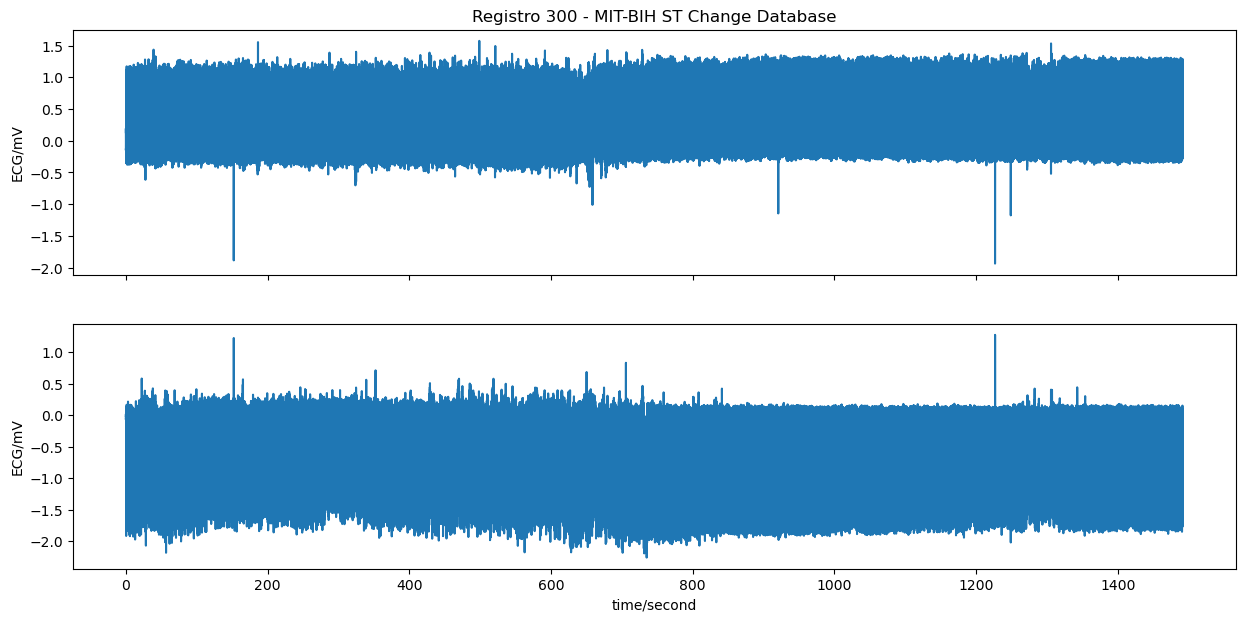

Parámetros del registro:
- Nombre del registro: 300
- Cantidad de señales: 2
- Frecuencia de muestreo: 360
- Longitud de las señales: 536976


In [3]:
# carga de la señal utilizando el paquete WFDB
record = wfdb.rdrecord('300', pn_dir='stdb') 
wfdb.plot_wfdb(record=record, time_units='seconds', figsize=(15, 7),
               title='Registro 300 - MIT-BIH ST Change Database') 

print("Parámetros del registro:")
print(f"- Nombre del registro: {record.record_name}")
print(f"- Cantidad de señales: {record.n_sig}")
print(f"- Frecuencia de muestreo: {record.fs}")
print(f"- Longitud de las señales: {record.sig_len}")

### Definición de parámetros temporales:

In [4]:
# se extraen los parámetros de la señal correspondiente al primer canal del registro
senial = record.p_signal[:, 0]
fs = record.fs
N = record.sig_len                      # número de muestras
ts = 1 / fs                             # tiempo de muestreo
t = np.linspace(0, N * ts, N)           # vector de tiempo

### Cálculo de la FFT

In [5]:
def fft_mag(x, fs):
    freq = fft.fftfreq(len(x), d=1/fs)   # se genera el vector de frecuencias
    senial_fft = fft.fft(x)    # se calcula la transformada rápida de Fourier

    # El espectro es simétrico, nos quedamos solo con el semieje positivo
    f = freq[np.where(freq >= 0)]      
    senial_fft = senial_fft[np.where(freq >= 0)]

    # Se calcula la magnitud del espectro
    mag = np.abs(senial_fft) / len(x)    # Respetando la relación de Parceval
    # Al haberse descartado la mitad del espectro, para conservar la energía 
    # original de la señal, se debe multiplicar la mitad restante por dos (excepto
    # en 0 y fm/2)
    mag[1:len(mag)-1] = 2 * mag[1:len(mag)-1]
    
    return f, mag

In [6]:
f, senial_fft_mod = fft_mag(senial, fs)

### Graficación 

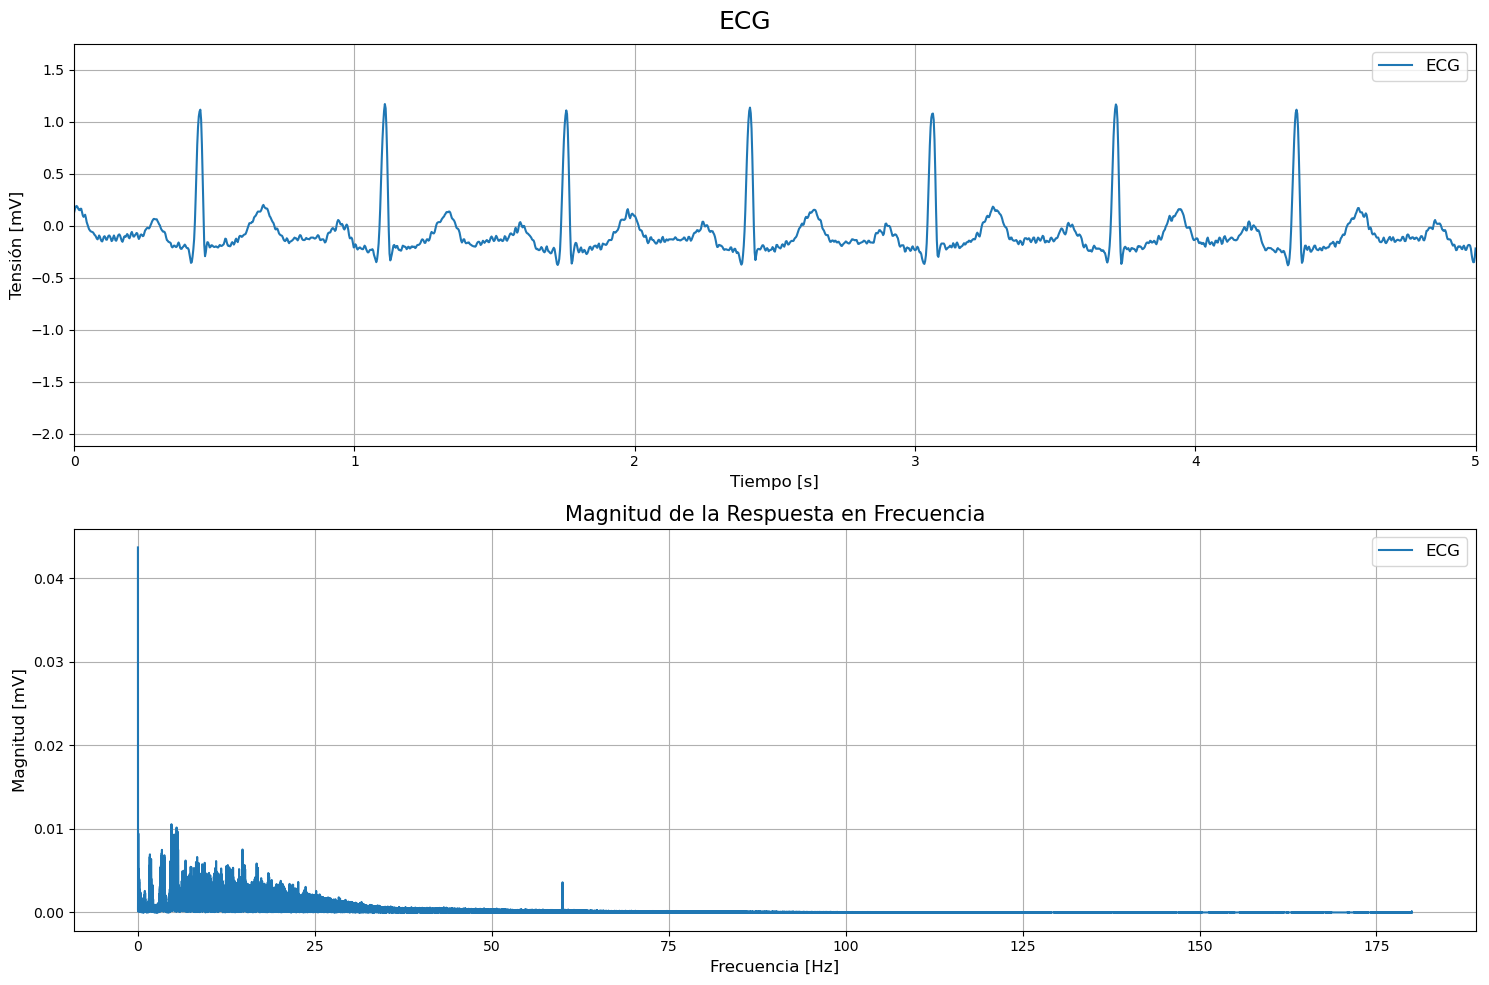

In [7]:
# Se crea una gráfica 
fig1, ax1 = plt.subplots(2, 1, figsize=(15, 10))
fig1.suptitle(record.sig_name[0], fontsize=18)

# Se grafica la señal
ax1[0].plot(t, senial, label=record.sig_name[0])
ax1[0].set_xlabel('Tiempo [s]', fontsize=12)
ax1[0].set_ylabel('Tensión [mV]', fontsize=12)
ax1[0].set_xlim([0, 5])
ax1[0].grid()
ax1[0].legend(fontsize=12)

# se grafica la magnitud de la respuesta en frecuencia
ax1[1].plot(f, senial_fft_mod, label=record.sig_name[0])
ax1[1].set_xlabel('Frecuencia [Hz]', fontsize=12)
ax1[1].set_ylabel('Magnitud [mV]', fontsize=12)
ax1[1].set_title('Magnitud de la Respuesta en Frecuencia', fontsize=15)
#ax1[1].set_xlim([0, 100])
ax1[1].grid()
ax1[1].legend(fontsize=12)

plt.tight_layout()
plt.show()

### Filtrado de las señales

In [8]:
# Diseño o carga de los filtros

# se cargan los filtro diseñado mediante pyFDA
filtro_iir = np.load('filtro_iir.npz', allow_pickle=True)
filtro_fir = np.load('filtro_fir.npz', allow_pickle=True)

# se extraen los coeficientes
num_iir_2, den_iir_2 = filtro_iir['ba']  
sos_iir_2 = signal.tf2sos(num_iir_2, den_iir_2)
num_fir_2, den_fir_2 = filtro_fir['ba'] 

In [9]:
# filtrado de la señal
senial_iir = signal.sosfilt(sos_iir_2, senial)
senial_fir = signal.lfilter(num_fir_2, 1, senial)

# cálculo del espectro de las señales
f_, fft_senial = fft_mag(senial, fs)
f_, fft_senial_iir_f = fft_mag(senial_iir, fs)
f_, fft_senial_fir = fft_mag(senial_fir, fs)

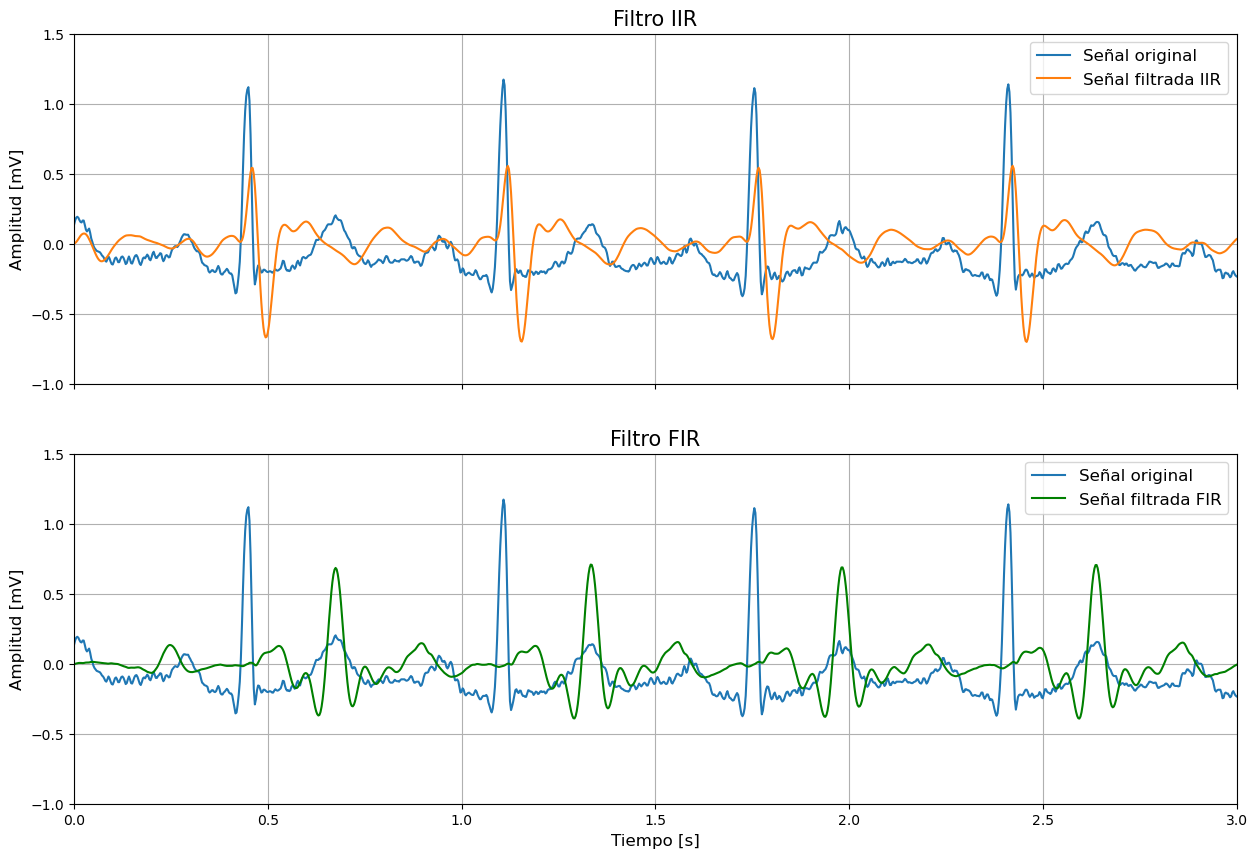

In [10]:
# graficación de las señales
fig2, ax2 = plt.subplots(2, 1, figsize=(15, 10), sharex=True)
ax2[0].plot(t, senial, label='Señal original')
ax2[0].plot(t, senial_iir, label='Señal filtrada IIR')
ax2[0].set_ylabel('Amplitud [mV]', fontsize=12)
ax2[0].legend(loc="upper right", fontsize=12)
ax2[0].set_title('Filtro IIR', fontsize=15)
ax2[0].set_ylim([-1, 1.5])
ax2[0].grid()

ax2[1].plot(t, senial, label='Señal original')
ax2[1].plot(t, senial_fir, label='Señal filtrada FIR', color='g')
ax2[1].set_ylabel('Amplitud [mV]', fontsize=12)
ax2[1].set_xlabel('Tiempo [s]', fontsize=12)
ax2[1].legend(loc="upper right", fontsize=12)
ax2[1].set_title('Filtro FIR', fontsize=15)
ax2[1].set_xlim([0, 3])
ax2[1].set_ylim([-1, 1.5])
ax2[1].grid()

plt.show()

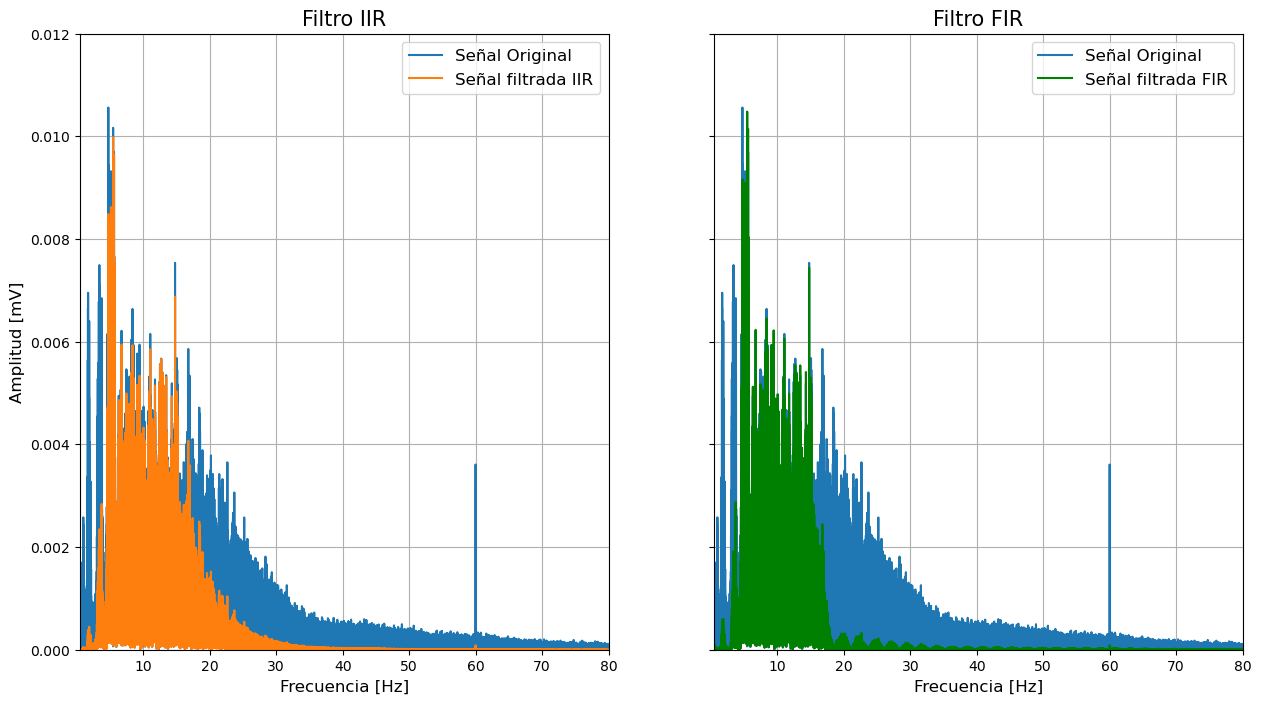

In [11]:
# graficación de los espectros
fig3, ax3 = plt.subplots(1, 2, figsize=(15, 8), sharey=True)
ax3[0].plot(f_, fft_senial, label='Señal Original')
ax3[0].plot(f_, fft_senial_iir_f, label='Señal filtrada IIR')
ax3[0].set_ylabel('Amplitud [mV]', fontsize=12)
ax3[0].set_xlabel('Frecuencia [Hz]', fontsize=12)
ax3[0].legend(loc="upper right", fontsize=12)
ax3[0].set_title('Filtro IIR', fontsize=15)
ax3[0].set_xlim([0.5, 80])
ax3[0].grid()

ax3[1].plot(f_, fft_senial, label='Señal Original')
ax3[1].plot(f_, fft_senial_fir, label='Señal filtrada FIR', color='g')
ax3[1].set_xlabel('Frecuencia [Hz]', fontsize=12)
ax3[1].legend(loc="upper right", fontsize=12)
ax3[1].set_title('Filtro FIR', fontsize=15)
ax3[1].set_xlim([0.5, 80])
ax3[1].set_ylim([0, 0.012])
ax3[1].grid()

plt.show()